In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

In [2]:
# Configure matplotlib
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 14
})

In [3]:
# Load the log file
log_file = 'log_files/logxxxx.log'
data = pd.read_csv(log_file)

print("Columns:", data.columns.tolist())
print(f"\nTotal data points: {len(data)}")

Columns: ['time', 'x', 'y', 'z', 'yaw', 'ctrl_comp_time', 'rollout_comptime', 'x_ref', 'y_ref', 'z_ref', 'yaw_ref', 'throttle', 'roll_rate', 'pitch_rate', 'yaw_rate', 'save_tube_pyH', 'save_tube_pyL', 'save_tube_pzH', 'save_tube_pzL']

Total data points: 5535


In [4]:
# Extract relevant data and FLIP Z
time = data['time'].values
y = data['y'].values
z = -data['z'].values  # FLIP Z
y_ref = data['y_ref'].values
z_ref = -data['z_ref'].values  # FLIP Z

# Reachable tube bounds - FLIP Z
pyH = data['save_tube_pyH'].values  # y upper bound
pyL = data['save_tube_pyL'].values  # y lower bound
pzH = -data['save_tube_pzL'].values  # z upper bound (FLIPPED - note swap of H and L)
pzL = -data['save_tube_pzH'].values  # z lower bound (FLIPPED - note swap of H and L)

# Get yaw if available
if 'yaw' in data.columns:
    yaw = data['yaw'].values
else:
    yaw = np.zeros_like(time)

print(f"Time range: {time[0]:.2f} to {time[-1]:.2f} seconds")
print(f"Duration: {time[-1] - time[0]:.2f} seconds")
print(f"Y range: {np.nanmin(y):.2f} to {np.nanmax(y):.2f}")
print(f"Z range: {np.nanmin(z):.2f} to {np.nanmax(z):.2f}")
print(f"\nTube Y width range: {np.nanmin(pyH - pyL):.3f} to {np.nanmax(pyH - pyL):.3f}")
print(f"Tube Z height range: {np.nanmin(pzH - pzL):.3f} to {np.nanmax(pzH - pzL):.3f}")

Time range: 15.00 to nan seconds
Duration: nan seconds
Y range: -0.46 to 3.88
Z range: 1.53 to 12.42

Tube Y width range: 0.001 to 9.494
Tube Z height range: 0.001 to 9.550


In [5]:
# Helper function to draw a quad (similar to the original notebook)
def quadplot(ypos, zpos, rot, scale):
    ts = -0.5 * np.arange(np.pi, 3/2 * np.pi, 0.2) + 0.3
    xtemp = np.cos(ts)
    ytemp = np.sin(ts) * np.cos(ts)

    xs = np.hstack((0.4*xtemp - 1, -1, -1, 1, 1, 0.4*xtemp + 1))
    ys = np.hstack((0.3*ytemp + 0.4, 0.4, 0, 0, 0.4, 0.3*ytemp + 0.4))
    xs = scale * xs
    ys = scale * ys
    
    rotmat = np.array([[np.cos(rot), -np.sin(rot)], 
                       [np.sin(rot), np.cos(rot)]])
    newpos = rotmat @ np.vstack((xs, ys))
    xs = newpos[0, :] + ypos
    ys = newpos[1, :] + zpos
    
    return xs, ys

Figure initialized


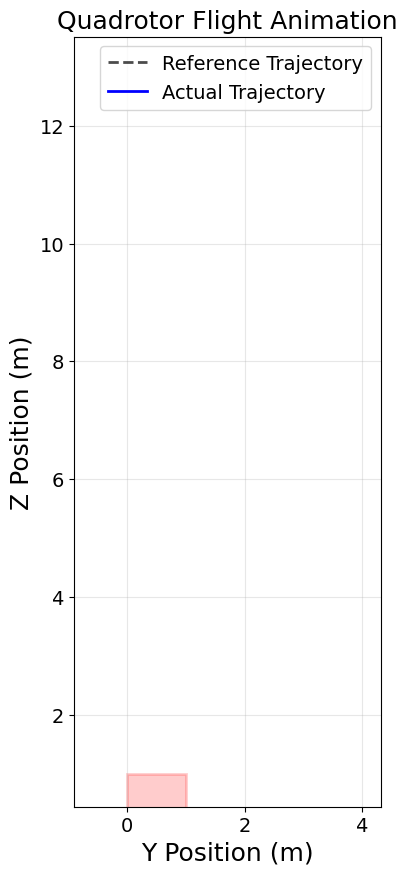

In [6]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

FONTSIZE = 18
LINEWIDTH = 2
QUADSIZE = 0.2

# Initialize plot elements
reference_line, = ax.plot([], [], label='Reference Trajectory', 
                          linestyle='dashed', color='black', linewidth=LINEWIDTH, alpha=0.7)

actual_line, = ax.plot([], [], label='Actual Trajectory', 
                       color='blue', linewidth=LINEWIDTH)

# Reachable tube rectangle
tube_rect = Rectangle((0, 0), 1, 1, linewidth=2, 
                      edgecolor='red', facecolor='red', alpha=0.2)
ax.add_patch(tube_rect)

# Quadrotor representation
quad_line, = ax.plot([], [], color='black', linewidth=LINEWIDTH)

# Set up the plot
ax.set_xlabel('Y Position (m)', fontsize=FONTSIZE)
ax.set_ylabel('Z Position (m)', fontsize=FONTSIZE)
ax.set_title('Quadrotor Flight Animation', fontsize=FONTSIZE)
ax.legend(loc='upper right', fontsize=FONTSIZE - 4)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

# Set axis limits based on data (handle NaNs)
y_margin = (np.nanmax(y) - np.nanmin(y)) * 0.1
z_margin = (np.nanmax(z) - np.nanmin(z)) * 0.1
ax.set_xlim(np.nanmin(y) - y_margin, np.nanmax(y) + y_margin)
ax.set_ylim(np.nanmin(z) - z_margin, np.nanmax(z) + z_margin)

# Time text
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                    fontsize=FONTSIZE, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

print("Figure initialized")

In [7]:
# Animation function
def update(frame):
    # Update reference trajectory up to current frame
    reference_line.set_data(y_ref[:frame+1], z_ref[:frame+1])
    
    # Update actual trajectory up to current frame
    actual_line.set_data(y[:frame+1], z[:frame+1])
    
    # Update reachable tube rectangle (handle NaNs)
    if not (np.isnan(pyH[frame]) or np.isnan(pyL[frame]) or 
            np.isnan(pzH[frame]) or np.isnan(pzL[frame])):
        tube_width = pyH[frame] - pyL[frame]
        tube_height = pzH[frame] - pzL[frame]
        
        # Only draw if dimensions are reasonable
        if tube_width > 0 and tube_height > 0 and tube_width < 100 and tube_height < 100:
            tube_rect.set_xy((pyL[frame], pzL[frame]))
            tube_rect.set_width(tube_width)
            tube_rect.set_height(tube_height)
            tube_rect.set_visible(True)
        else:
            tube_rect.set_visible(False)
    else:
        tube_rect.set_visible(False)
    
    # Update quadrotor position (handle NaNs)
    if not (np.isnan(y[frame]) or np.isnan(z[frame])):
        yaw_val = yaw[frame] if not np.isnan(yaw[frame]) else 0
        quad_y, quad_z = quadplot(y[frame], z[frame], yaw_val, QUADSIZE)
        quad_line.set_data(quad_y, quad_z)
        quad_line.set_visible(True)
    else:
        quad_line.set_visible(False)
    
    # Update time text
    time_text.set_text(f't = {time[frame]:.2f} s')
    
    return reference_line, actual_line, tube_rect, quad_line, time_text

In [8]:
# Calculate frame skip based on time for smooth animation
# Target: show animation at real-time or faster
# Calculate average time between samples (handle NaNs)
time_diffs = np.diff(time)
valid_diffs = time_diffs[~np.isnan(time_diffs)]

if len(valid_diffs) > 0:
    avg_dt = np.mean(valid_diffs)
else:
    avg_dt = 0.01  # Default to 10ms if no valid differences

print(f"Average time between samples: {avg_dt:.4f} seconds")

# Skip frames to make animation run smoothly
# Adjust this to control animation speed
skip_frames = max(1, int(0.05 / avg_dt))  # Aim for 50ms between frames
print(f"Skip frames: {skip_frames}")

frames_to_use = list(range(0, len(time), skip_frames))
print(f"Total frames to animate: {len(frames_to_use)}")

# Calculate interval in ms based on actual time differences
interval_ms = 50  # 50ms = 20 fps
print(f"Animation interval: {interval_ms} ms")

Average time between samples: 0.0181 seconds
Skip frames: 2
Total frames to animate: 2768
Animation interval: 50 ms


In [ ]:
# Create and save the animation
print("Creating animation...")
ani = animation.FuncAnimation(fig, update, frames=frames_to_use, 
                             interval=interval_ms, blit=True, repeat=True)

print("Saving animation as GIF (this may take a while)...")
ani.save('log_animation.gif', writer='pillow', fps=20)
print("Animation saved as 'log_animation.gif'!")

plt.show()

Creating animation...
Saving animation as GIF (this may take a while)...
